In [1]:
%reload_ext autoreload
%autoreload 2

# Load the data

In [1]:
from Scratch import metadata_loader
import numpy as np
from tqdm import tqdm

DEVICE = "ibm_sherbrooke"
LOGICAL = str(0)
pairs_to_process = [(10, 10), (20, 20), (30, 35), (40, 35), (55, 35)]

# Load the metadata
md = metadata_loader(True, True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["code"] == "RepetitionCodeCircuit"]
md = md.dropna(subset=["rounds"])
md = md[md["meas_level"] == 1]
md['rounds'] = md['rounds'].astype(int)
md['distance'] = md['distance'].astype(int)

md = md[md["backend_name"] == DEVICE]
md = md[md["logical"] == LOGICAL]

# Load results

In [2]:
import json

with open("../results/infoPerfo_v1.json", "r") as f:
    decoding_results = json.load(f)

print(decoding_results)

{'cnn25s724wx0008f9kz0': [{'decoding': 'grid', 'num_errors': 2, 'nb_intervals': 1}, {'decoding': 'kde', 'num_errors': 17, 'nb_intervals': 1, 'additional_info': {'rel_error': 1, 'bandwidth_linspace': [0.4, 0.7, 20], 'num_points_bandwidths': 51}}, {'decoding': 'grid', 'num_errors': 0, 'nb_intervals': 3}, {'decoding': 'kde', 'num_errors': 2, 'nb_intervals': 3, 'additional_info': {'rel_error': 1, 'bandwidth_linspace': [0.4, 0.7, 20], 'num_points_bandwidths': 51}}, {'decoding': 'grid', 'num_errors': 0, 'nb_intervals': 6}, {'decoding': 'kde', 'num_errors': 3, 'nb_intervals': 6, 'additional_info': {'rel_error': 1, 'bandwidth_linspace': [0.4, 0.7, 20], 'num_points_bandwidths': 51}}, {'decoding': 'grid', 'num_errors': 0, 'nb_intervals': 8}, {'decoding': 'kde', 'num_errors': 0, 'nb_intervals': 8, 'additional_info': {'rel_error': 1, 'bandwidth_linspace': [0.4, 0.7, 20], 'num_points_bandwidths': 51}}, {'decoding': 'grid', 'num_errors': 1, 'nb_intervals': 11}, {'decoding': 'kde', 'num_errors': 1, '

# Get the cummulative error dict

In [3]:
pairs_to_process = [(10, 10), (20, 20), (30, 35), (40, 35), (55, 35)]

# Initialize the dictionary with the new structure
err_rates_dict = {pair: [{}, 0] for pair in pairs_to_process}

# Assuming md and decoding_results are defined
for index, row in md.iterrows():
    if (row["distance"], row["rounds"]) not in pairs_to_process:
        continue
    
    decoding_result = decoding_results[row["job_id"]]
    # Add the shots to the total
    err_rates_dict[(row["distance"], row["rounds"])][1] += row["shots"]
    
    # Add the errors to the dictionary, now considering nb_intervals
    for decoding_entry in decoding_result:
        decoding = decoding_entry["decoding"]
        nb_intervals = decoding_entry["nb_intervals"]
        num_errors = decoding_entry["num_errors"]
        
        if decoding not in err_rates_dict[(row["distance"], row["rounds"])][0]:
            err_rates_dict[(row["distance"], row["rounds"])][0][decoding] = {nb_intervals: num_errors}
        else:
            if nb_intervals not in err_rates_dict[(row["distance"], row["rounds"])][0][decoding]:
                err_rates_dict[(row["distance"], row["rounds"])][0][decoding][nb_intervals] = num_errors
            else:
                err_rates_dict[(row["distance"], row["rounds"])][0][decoding][nb_intervals] += num_errors

print(err_rates_dict)


{(10, 10): [{'grid': {1: 373, 14: 120, 28: 118, 42: 112, 56: 117, 70: 114, 83: 116, 97: 117, 111: 117, 125: 113, 139: 116, 153: 114, 166: 111, 180: 112, 194: 114, 208: 115, 222: 113, 236: 112, 249: 113, 263: 115, 277: 115, 291: 114, 305: 114, 318: 111, 332: 114, 346: 115, 360: 112, 374: 113, 388: 114, 401: 113, 415: 115, 429: 114, 443: 114, 457: 114, 471: 113, 484: 115, 498: 114, 512: 114, 526: 115, 540: 114, 553: 113, 567: 113, 581: 113, 595: 114, 609: 112, 623: 114, 636: 113, 650: 114, 664: 115, 678: 114, 692: 115, 706: 115, 719: 114, 733: 114, 747: 113, 761: 114, 775: 114, 788: 112, 802: 114, 816: 114, 830: 115, 844: 114, 858: 114, 871: 114, 885: 115, 899: 113, 913: 116, 927: 115, 941: 115, 954: 114, 968: 115, 982: 115, 996: 115, 1010: 114, 1024: 115}, 'kde': {1: 240, 14: 161, 28: 146, 42: 134, 56: 127, 70: 124, 83: 122, 97: 119, 111: 116, 125: 116, 139: 114, 153: 114, 166: 114, 180: 114, 194: 115, 208: 114, 222: 113, 236: 113, 249: 116, 263: 114, 277: 112, 291: 112, 305: 114, 318: 

# Append the nb_intervals = -1 to the end of the dict

In [4]:

with open("../results/softInfo_vs_informed.json", "r") as f:
    decoding_results_no_int = json.load(f)

for index, row in md.iterrows():
    if (row["distance"], row["rounds"]) not in pairs_to_process:
        continue
    
    decoding_result = decoding_results_no_int[row["job_id"]]
    
    # Add the errors to the dictionary, now considering nb_intervals
    for decoding_entry in decoding_result:
        decoding = decoding_entry["decoding"]
        if decoding not in ["grid", "kde"]:
            continue
        num_errors = decoding_entry["num_errors"]
        if -1 not in err_rates_dict[(row["distance"], row["rounds"])][0][decoding]:
            err_rates_dict[(row["distance"], row["rounds"])][0][decoding][-1] = num_errors
        else:
            err_rates_dict[(row["distance"], row["rounds"])][0][decoding][-1] += num_errors

print(err_rates_dict)

{(10, 10): [{'grid': {1: 373, 14: 120, 28: 118, 42: 112, 56: 117, 70: 114, 83: 116, 97: 117, 111: 117, 125: 113, 139: 116, 153: 114, 166: 111, 180: 112, 194: 114, 208: 115, 222: 113, 236: 112, 249: 113, 263: 115, 277: 115, 291: 114, 305: 114, 318: 111, 332: 114, 346: 115, 360: 112, 374: 113, 388: 114, 401: 113, 415: 115, 429: 114, 443: 114, 457: 114, 471: 113, 484: 115, 498: 114, 512: 114, 526: 115, 540: 114, 553: 113, 567: 113, 581: 113, 595: 114, 609: 112, 623: 114, 636: 113, 650: 114, 664: 115, 678: 114, 692: 115, 706: 115, 719: 114, 733: 114, 747: 113, 761: 114, 775: 114, 788: 112, 802: 114, 816: 114, 830: 115, 844: 114, 858: 114, 871: 114, 885: 115, 899: 113, 913: 116, 927: 115, 941: 115, 954: 114, 968: 115, 982: 115, 996: 115, 1010: 114, 1024: 115, -1: 115}, 'kde': {1: 240, 14: 161, 28: 146, 42: 134, 56: 127, 70: 124, 83: 122, 97: 119, 111: 116, 125: 116, 139: 114, 153: 114, 166: 114, 180: 114, 194: 115, 208: 114, 222: 113, 236: 113, 249: 116, 263: 114, 277: 112, 291: 112, 305: 1

# Plot the infoPerfo tradeoff

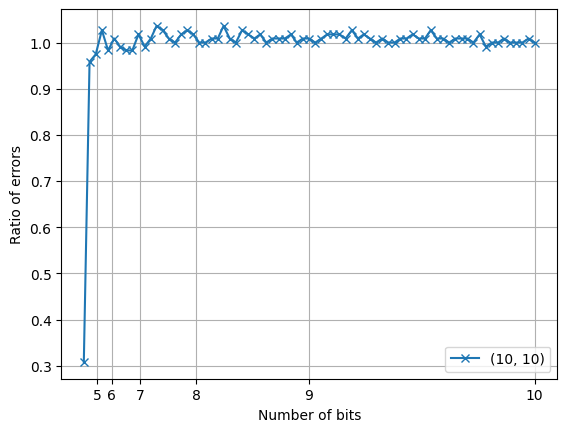

In [5]:
import matplotlib.pyplot as plt
import numpy as np

err_rates_informed = []
err_rates_kde = []

i = 0
for pair, (err_rate_dict, _) in err_rates_dict.items():
    i += 1
    if i != 1:
        continue

    bits_grid = list(err_rate_dict["grid"].keys())
    errs_grid = list(err_rate_dict["grid"].values())

    ratios = [errs_grid[-1]/(err + 1e-8) for err in errs_grid[:-1]]
    bits = bits_grid[:-1]
    
    plt.plot(bits, ratios, label=f"{pair}", marker="x")

# plt.xscale("log")
plt.xticks([2**i for i in range(5, 11)], labels=[f"{i}" for i in range(5, 11)])
plt.xlabel("Number of bits")
plt.ylabel("Ratio of errors")
plt.legend()
plt.grid()


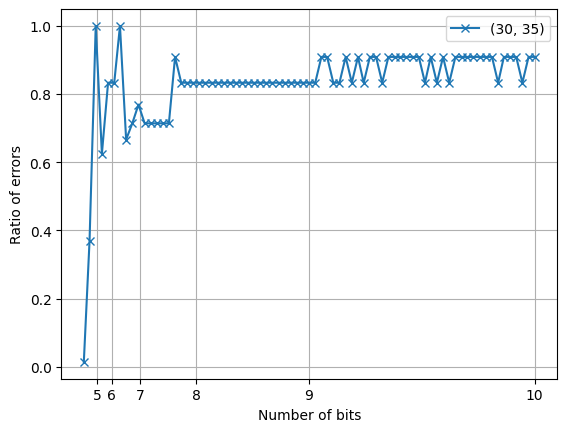

In [6]:
import matplotlib.pyplot as plt
import numpy as np

err_rates_informed = []
err_rates_kde = []

i = 0
for pair, (err_rate_dict, _) in err_rates_dict.items():
    i += 1
    if i != 3:
        continue

    bits_kde = list(err_rate_dict["kde"].keys())
    errs_kde = list(err_rate_dict["kde"].values())

    ratios = [errs_kde[-1]/(err + 1e-8) for err in errs_kde[:-1]]
    bits = bits_kde[:-1]
    
    plt.plot(bits, ratios, label=f"{pair}", marker="x")

# plt.xscale("log")
plt.xticks([2**i for i in range(5, 11)], labels=[f"{i}" for i in range(5, 11)])
plt.xlabel("Number of bits")
plt.ylabel("Ratio of errors")
plt.legend()
plt.grid()


# Plot the error rates instead of ratio

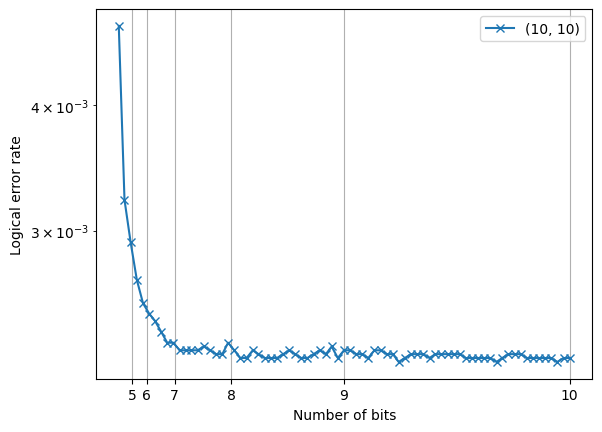

In [96]:
import matplotlib.pyplot as plt
import numpy as np

err_rates_informed = []
err_rates_kde = []

i = 0
for pair, (err_rate_dict, shots) in err_rates_dict.items():
    i += 1
    if i != 1:
        continue

    bits_kde = list(err_rate_dict["kde"].keys())
    errs_kde = list(err_rate_dict["kde"].values())


    bits = bits_kde[:-1]
    err_rates = [err/shots for err in errs_kde][:-1]
    
    plt.plot(bits, err_rates, label=f"{pair}", marker="x")

# plt.xscale("log")
plt.yscale("log")
plt.xticks([2**i for i in range(5, 11)], labels=[f"{i}" for i in range(5, 11)])
# plt.yticks(ticks=[0.001, 0.003, 0.006, 0.01], labels=["0.1%", "0.3%", "0.6%", "1%"])

plt.xlabel("Number of bits")
plt.ylabel("Logical error rate")
plt.legend()
plt.grid()


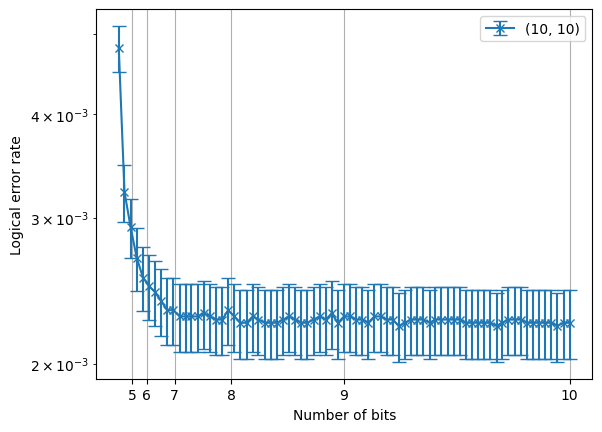

In [102]:
import matplotlib.pyplot as plt
import numpy as np

err_rates_informed = []
err_rates_kde = []

i = 0
for pair, (err_rate_dict, shots) in err_rates_dict.items():
    i += 1
    if i != 1:
        continue

    bits_kde = list(err_rate_dict["kde"].keys())
    errs_kde = list(err_rate_dict["kde"].values())

    bits = bits_kde[:-1]
    err_rates = [err/shots for err in errs_kde][:-1]

    # Calculate standard errors for the error rates
    standard_errors = [np.sqrt((rate * (1 - rate)) / shots) for rate in err_rates]
    standard_errors = [np.sqrt((rate) / shots) for rate in err_rates]
    
    # Plot with error bars
    plt.errorbar(bits, err_rates, yerr=standard_errors, label=f"{pair}", fmt='x-', capsize=5)

plt.yscale("log")
plt.xticks([2**i for i in range(5, 11)], labels=[f"{i}" for i in range(5, 11)])
plt.xlabel("Number of bits")
plt.ylabel("Logical error rate")
plt.legend()
plt.grid(True)
plt.show()


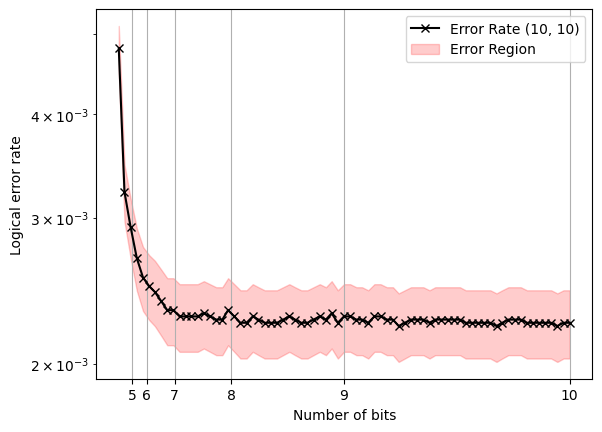

In [108]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

err_rates_informed = []
err_rates_kde = []

i = 0
for pair, (err_rate_dict, shots) in err_rates_dict.items():
    i += 1
    if i != 1:
        continue

    bits_kde = list(err_rate_dict["kde"].keys())
    errs_kde = list(err_rate_dict["kde"].values())

    bits = bits_kde[:-1]
    err_rates = [err/shots for err in errs_kde][:-1]
    
    standard_errors = [np.sqrt(rate / shots) for rate in err_rates]
    
    # Upper and lower bounds for the error region
    err_rates_upper = [rate + error for rate, error in zip(err_rates, standard_errors)]
    err_rates_lower = [max(rate - error, 1e-10) for rate, error in zip(err_rates, standard_errors)]  # Avoid negative values

    # Plot the central line
    line = plt.plot(bits, err_rates, 'x-', color='black', label=f"Error Rate {pair}")

    # Plot the error region with alpha for transparency
    plt.fill_between(bits, err_rates_lower, err_rates_upper, color='red', alpha=0.2)

# Create a patch for the error region to add to the legend
error_patch = mpatches.Patch(color='red', alpha=0.2, label='Error Region')

# Add both the line and the error patch to the legend
plt.legend(handles=[line[0], error_patch])

plt.yscale("log")
plt.xticks([2**i for i in range(5, 11)], labels=[f"{i}" for i in range(5, 11)])
plt.xlabel("Number of bits")
plt.ylabel("Logical error rate")
plt.grid(True)
plt.show()
